# Bijectors

> In this post, we are going to take a look at bijectors which are the objects intense flow probability that implemented by bijective or invertible transformations. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/gumbelCDF.png

## Packages

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

Bijector is the term of encapsulation in [change of variables](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables) for a probability density. Simply speaking, when we have some probability density function, and there is another mapping function, we can derive another density function for mapped variable.

### First simple bijector

In [4]:
z = tf.constant([1., 2., 3.])
scale = tfb.Scale(2.)

X = scale.forward(z)
X

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 4., 6.], dtype=float32)>

### Inverse operation of the bijector

In [5]:
scale.inverse(tf.constant([5., 3., 1.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.5, 1.5, 0.5], dtype=float32)>

### Combined with shift and scale bijector

In [6]:
scale = tfb.Scale(2.)
shift = tfb.Shift(1.)

# Chained with reverse order : scale -> shift
scale_and_shift = tfb.Chain([shift, scale])
scale_and_shift

In [7]:
scale_and_shift.forward(z)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 5., 7.], dtype=float32)>

In [8]:
scale_and_shift.inverse(tf.constant([2., 5., 8.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 2. , 3.5], dtype=float32)>

Same operation,

In [9]:
another_scale_and_shift = shift(scale)
another_scale_and_shift

In this case, object itself is equivalent to call forward method.

In [12]:
another_scale_and_shift(z)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 5., 7.], dtype=float32)>

In [10]:
another_scale_and_shift.forward(z)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 5., 7.], dtype=float32)>

In [11]:
another_scale_and_shift.inverse(tf.constant([2., 5., 8.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 2. , 3.5], dtype=float32)>

### Combined with normal distribution

In [13]:
normal = tfd.Normal(loc=0., scale=1.)
z = normal.sample(3)
z

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.31562603, -0.68124855, -0.8723412 ], dtype=float32)>

In [14]:
scale_and_shift = tfb.Chain([tfb.Shift(1.), tfb.Scale(2.)])
x = scale_and_shift.forward(z)
x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.631252  , -0.3624971 , -0.74468243], dtype=float32)>

In [15]:
log_prob_z = normal.log_prob(z)
log_prob_z

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.9687484, -1.1509883, -1.2994281], dtype=float32)>

### Log Determinant Jacobian

In [16]:
# event_ndims: number of event space dimensions present in the input tensor z
log_prob_x = log_prob_z - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0) 
log_prob_x

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.6618955, -1.8441355, -1.9925753], dtype=float32)>

## Tutorials

### Bijectors

In [17]:
# Define base distributions

normal = tfd.Normal(loc=0., scale=1.)

In [18]:
# Sample from base distribution

n = 10000
z = normal.sample(n)

### Scale and shift bijector

In [19]:
# Define scale and shift

scale = 4.5
shift = 7

In [20]:
# Define chain bijector

scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

In [21]:
# We can also use call methods

scale_transform = tfb.Scale(scale)
shift_transform = tfb.Shift(shift)
scale_and_shift_temp = shift_transform(scale_transform)

In [22]:
# Apply the forward transformation

x = scale_and_shift.forward(z)
x

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([14.471342  ,  8.549594  ,  1.2034626 , ...,  8.06999   ,
        0.17172766,  3.1396165 ], dtype=float32)>

In [23]:
# Check the forward transformation

tf.norm(x - (scale * z + shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

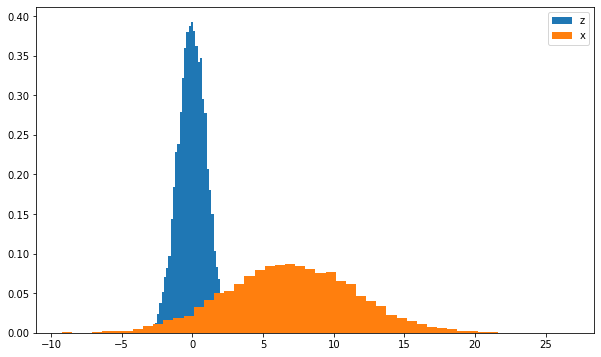

In [28]:
# Plot x and z density

plt.hist(z.numpy(), bins=50, density=True, label='z')
plt.hist(x.numpy(), bins=50, density=True, label='x')
plt.legend()
plt.show()

### Inverse transformation

In [29]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(x)

In [30]:
# Check inverse transformation

tf.norm(inv_x - z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Log probability

In [32]:
# compute log prob for x

log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
log_prob_x

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-3.8013113, -2.482306 , -3.2526417, ..., -2.4512846, -3.5742579,
       -2.7909803], dtype=float32)>

In [34]:
# We can also use the inverse transformation

log_prob_x = normal.log_prob(scale_and_shift.inverse(x)) + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0)
log_prob_x

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-3.8013113, -2.482306 , -3.2526417, ..., -2.4512846, -3.5742579,
       -2.7909803], dtype=float32)>

### Broadcasting

In [35]:
x = tf.random.normal(shape=(100, 1))

In [37]:
# Softfloor bijector

softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)

(100, 1)


In [38]:
# Softfloor bijector using broadcasting
softfloor = tfb.Softfloor(temperature=[0.2, 1.])
y = softfloor.forward(x)
print(y.shape)

(100, 2)


In [40]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01, 0.1, 1.])
y = softfloor.forward(x)
print(y.shape)

(100, 3)


In [41]:
# Plot routines

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

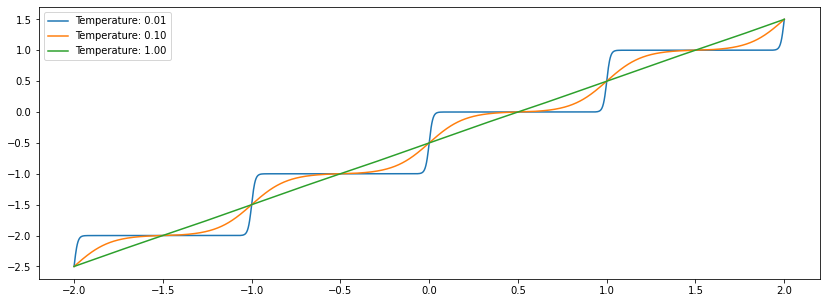

In [42]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]
_plot(3, softfloor, ['temperature'], x)

In [43]:
# Gumbel bijector using broadcasting

exps = tfb.GumbelCDF(loc=[0.5, 1., 1.5, 2., 3.], scale=[1, 2, 2, 3, 4])

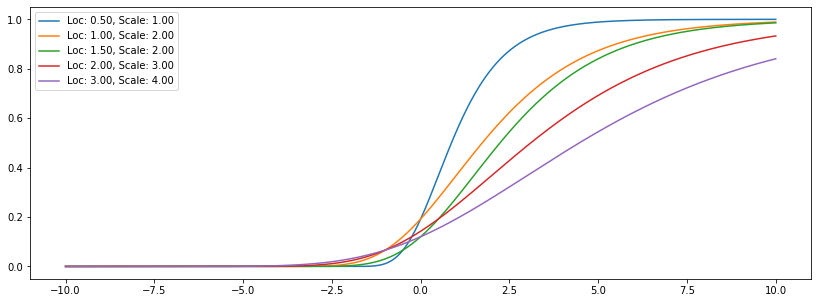

In [44]:
# Plot
x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5, exps, ['loc', 'scale'], x)